In [49]:
import os
import glob

# Define the path to your data folder and file pattern
data_folder = '/Users/nazanin/Desktop/interactive_map/data/'
file_pattern = os.path.join(data_folder, 'NLDAS_FORA0125_H.A*.nc4')

# Use glob to list all files matching the pattern
file_paths = sorted(glob.glob(file_pattern))

# Print out all the matching file paths
print("Files found:")
for file_path in file_paths:
    print(file_path)

print("\nNumber of files found:", len(file_paths))


Files found:
/Users/nazanin/Desktop/interactive_map/data/NLDAS_FORA0125_H.A20240531.0000.002.grb.SUB.nc4
/Users/nazanin/Desktop/interactive_map/data/NLDAS_FORA0125_H.A20240601.0000.002.grb.SUB.nc4
/Users/nazanin/Desktop/interactive_map/data/NLDAS_FORA0125_H.A20240602.0000.002.grb.SUB.nc4
/Users/nazanin/Desktop/interactive_map/data/NLDAS_FORA0125_H.A20240603.0000.002.grb.SUB.nc4
/Users/nazanin/Desktop/interactive_map/data/NLDAS_FORA0125_H.A20240604.0000.002.grb.SUB.nc4
/Users/nazanin/Desktop/interactive_map/data/NLDAS_FORA0125_H.A20240605.0000.002.grb.SUB.nc4
/Users/nazanin/Desktop/interactive_map/data/NLDAS_FORA0125_H.A20240606.0000.002.grb.SUB.nc4
/Users/nazanin/Desktop/interactive_map/data/NLDAS_FORA0125_H.A20240607.0000.002.grb.SUB.nc4

Number of files found: 8


In [50]:
for i, file_path in enumerate(file_paths):
    print(f"\nInspecting file {i+1}: {file_path}")
    dataset = xr.open_dataset(file_path)
    print(dataset)



Inspecting file 1: /Users/nazanin/Desktop/interactive_map/data/NLDAS_FORA0125_H.A20240531.0000.002.grb.SUB.nc4
<xarray.Dataset> Size: 5MB
Dimensions:   (time: 1, lon: 464, lat: 224, height: 1, height_2: 1, lev: 1)
Coordinates:
  * time      (time) datetime64[ns] 8B 2024-05-31
  * lon       (lon) float64 4kB -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * lat       (lat) float64 2kB 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
  * height    (height) float64 8B 2.0
  * height_2  (height_2) float64 8B 10.0
  * lev       (lev) float64 8B 180.0
Data variables:
    TMP       (time, height, lat, lon) float32 416kB ...
    SPFH      (time, height, lat, lon) float32 416kB ...
    PRES      (time, lat, lon) float32 416kB ...
    UGRD      (time, height_2, lat, lon) float32 416kB ...
    VGRD      (time, height_2, lat, lon) float32 416kB ...
    DLWRF     (time, lat, lon) float32 416kB ...
    CONVfrac  (time, lat, lon) float32 416kB ...
    CAPE      (time, lev, lat, lon) float32 416kB ...
 

In [51]:
import pandas as pd
dates = pd.date_range("2024-05-31", "2024-06-07", freq="D")
if len(file_paths) != len(dates):
    raise ValueError("The number of files does not match the number of dates.")

In [52]:
datasets = []
for file_path, date in zip(file_paths, dates):
    ds = xr.open_dataset(file_path)
    # Set the `time` coordinate to the date for this file
    ds = ds.assign_coords(time=("time", [date]))
    datasets.append(ds)

In [55]:
# Concatenate all datasets along the `time` dimension
combined_dataset = xr.concat(datasets, dim="time")

# Inspect the combined dataset
print(combined_dataset)

<xarray.Dataset> Size: 37MB
Dimensions:   (time: 8, height: 1, lat: 224, lon: 464, height_2: 1, lev: 1)
Coordinates:
  * lon       (lon) float64 4kB -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * lat       (lat) float64 2kB 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
  * height    (height) float64 8B 2.0
  * height_2  (height_2) float64 8B 10.0
  * lev       (lev) float64 8B 180.0
  * time      (time) datetime64[ns] 64B 2024-05-31 2024-06-01 ... 2024-06-07
Data variables:
    TMP       (time, height, lat, lon) float32 3MB nan nan nan ... 297.5 297.5
    SPFH      (time, height, lat, lon) float32 3MB nan nan ... 0.00951 0.009564
    PRES      (time, lat, lon) float32 3MB nan nan nan ... 9.366e+04 9.35e+04
    UGRD      (time, height_2, lat, lon) float32 3MB nan nan nan ... -1.27 -1.26
    VGRD      (time, height_2, lat, lon) float32 3MB nan nan nan ... 0.11 0.18
    DLWRF     (time, lat, lon) float32 3MB nan nan nan nan ... 383.9 383.6 381.1
    CONVfrac  (time, lat, lon) float32 3

In [56]:
output_path = os.path.join(data_folder, 'combined_data.nc')
combined_dataset.to_netcdf(output_path)
print(f"Combined dataset saved to {output_path}")


Combined dataset saved to /Users/nazanin/Desktop/interactive_map/data/combined_data.nc


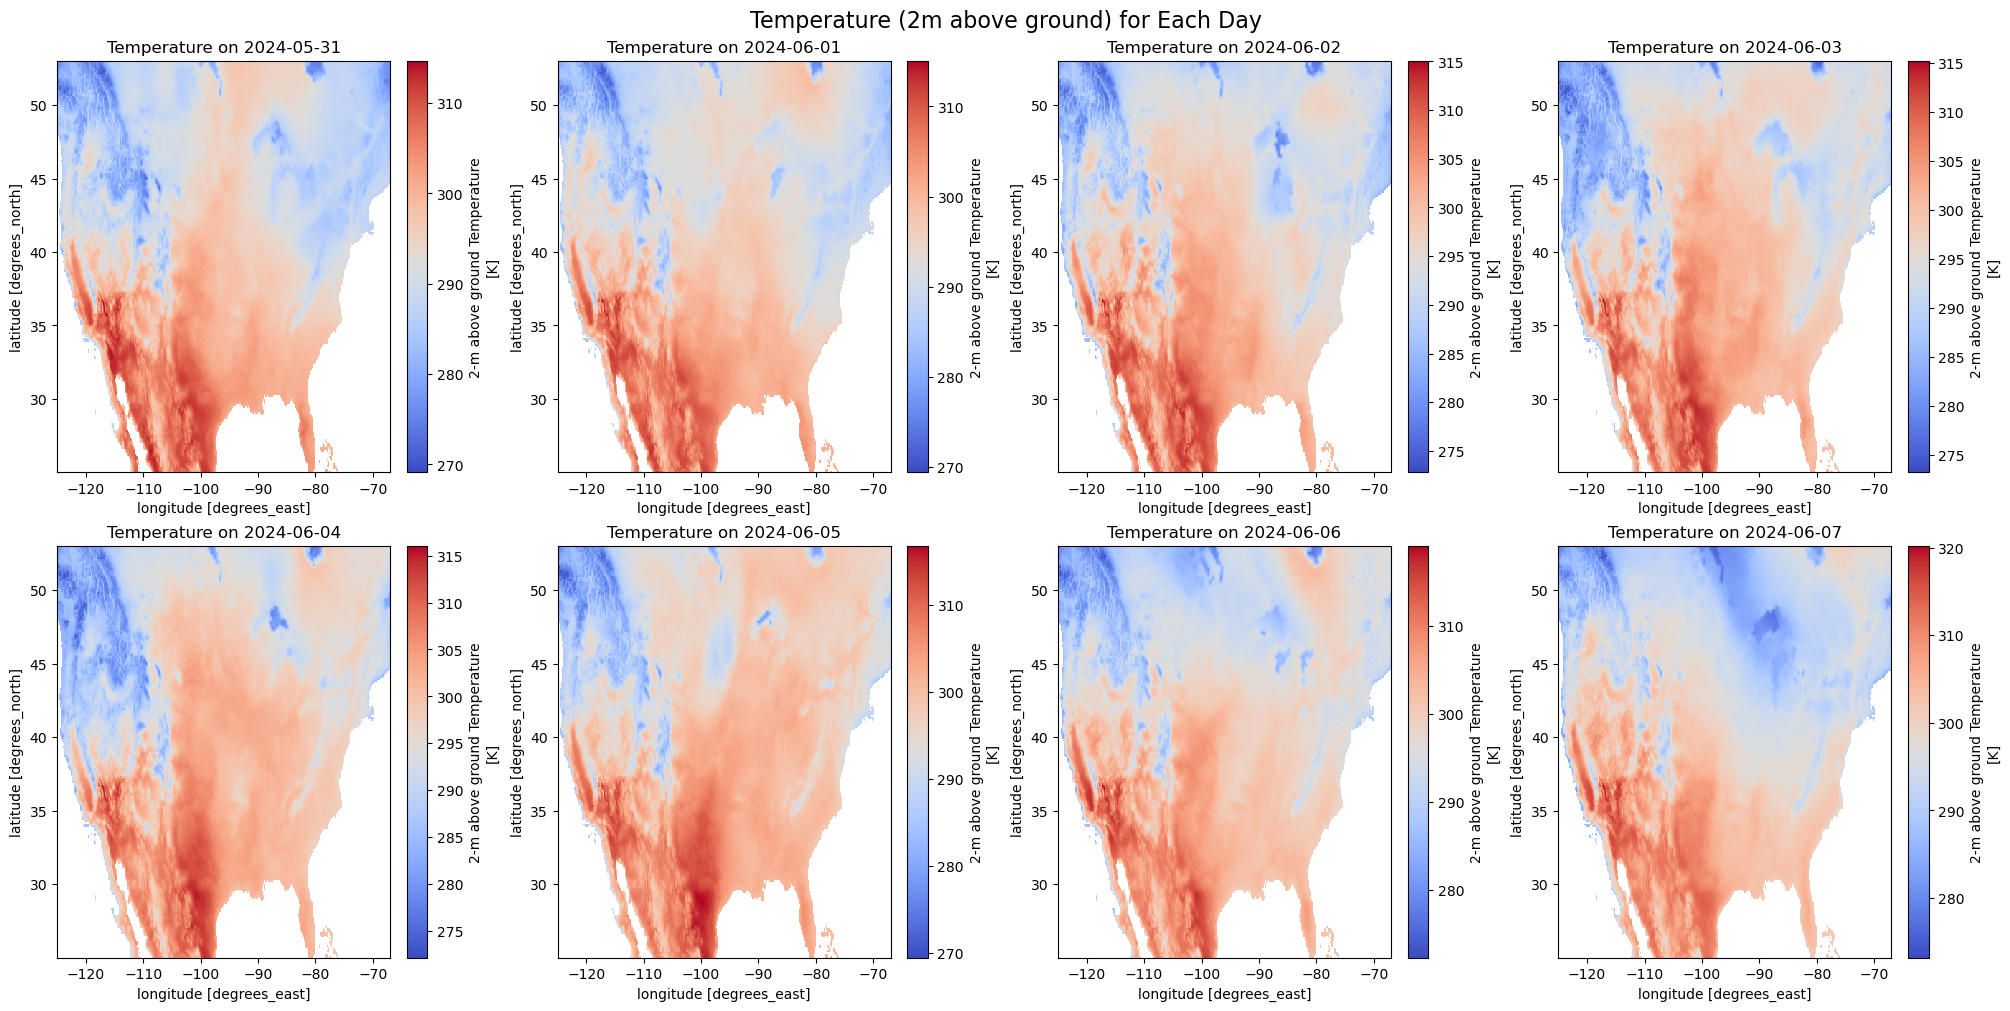

In [57]:
import matplotlib.pyplot as plt

# Select the variable to visualize (e.g., temperature at 2 meters)
variable = combined_dataset['TMP'].sel(height=2.0)

# Plot each day on a separate subplot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()

# Iterate over each time step (each day) and plot
for i, ax in enumerate(axes):
    if i < len(variable.time):
        day_data = variable.isel(time=i)
        day_data.plot(ax=ax, cmap='coolwarm')
        ax.set_title(f"Temperature on {str(variable.time.values[i])[:10]}")
    else:
        ax.axis('off')  # Turn off unused subplots if fewer than 8 days

plt.suptitle("Temperature (2m above ground) for Each Day", fontsize=16)
plt.show()


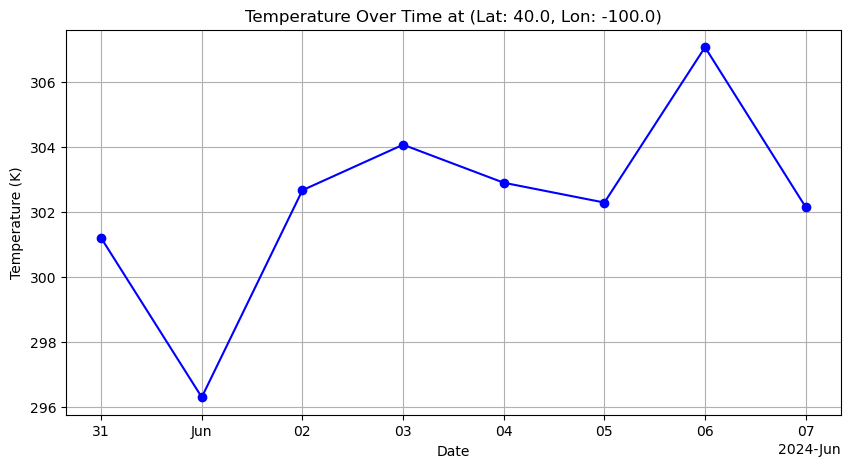

In [58]:
# Choose a location (latitude and longitude)
lat = 40.0  
lon = -100.0  

# Select the temperature variable at 2 meters above ground and the specified location
temp_location = combined_dataset['TMP'].sel(height=2.0, lat=lat, lon=lon, method="nearest")

# Plot temperature over time
plt.figure(figsize=(10, 5))
temp_location.plot(marker='o', color='b')
plt.title(f"Temperature Over Time at (Lat: {lat}, Lon: {lon})")
plt.xlabel("Date")
plt.ylabel("Temperature (K)")
plt.grid(True)
plt.show()


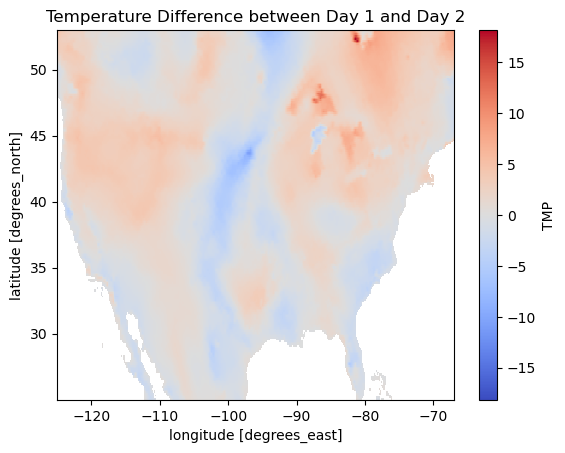

In [59]:
# Calculate the difference in temperature between each day
temp_diff = variable.diff(dim='time')

# Plot the difference for the first day as an example
temp_diff_day1 = temp_diff.isel(time=0)
temp_diff_day1.plot(cmap='coolwarm', center=0)
plt.title("Temperature Difference between Day 1 and Day 2")
plt.show()


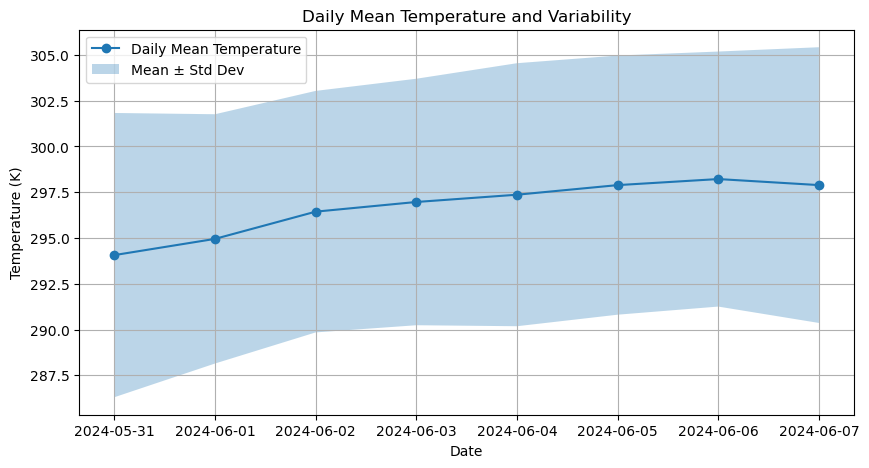

In [60]:
# Calculate mean and standard deviation of temperature for each day
daily_means = variable.mean(dim=['lat', 'lon'])
daily_stds = variable.std(dim=['lat', 'lon'])

# Plot the daily mean and standard deviation over time
plt.figure(figsize=(10, 5))
plt.plot(daily_means.time, daily_means, marker='o', label='Daily Mean Temperature')
plt.fill_between(daily_stds.time, daily_means - daily_stds, daily_means + daily_stds, alpha=0.3, label='Mean ± Std Dev')
plt.title("Daily Mean Temperature and Variability")
plt.xlabel("Date")
plt.ylabel("Temperature (K)")
plt.legend()
plt.grid()
plt.show()


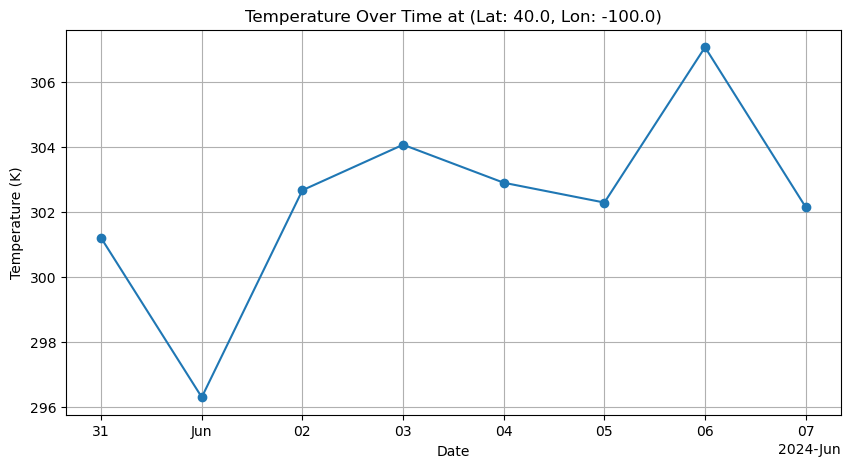

In [61]:
# Choose a specific location
lat, lon = 40.0, -100.0  # Adjust to a location of interest

# Select data for this location across all time steps
location_data = variable.sel(lat=lat, lon=lon, method="nearest")

# Plot data over time
plt.figure(figsize=(10, 5))
location_data.plot(marker='o')
plt.title(f"Temperature Over Time at (Lat: {lat}, Lon: {lon})")
plt.xlabel("Date")
plt.ylabel("Temperature (K)")
plt.grid()
plt.show()
